In [90]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh
import scipy as sps
import csv
#import pylab as plt
#import qutip as qt

In [91]:
omega  = 110.7          #mev
d      = 1.420          #angstrom, whatever is ok.
hv     = 1.5*d*2970     #meV*angstrom, Fermi velocity for SLG
N      = 5              #truncate range
valley = 1             #+1 for K, -1 for K'
I      = complex(0, 1)
ei120  = np.cos(2*np.pi/3) + valley*I*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - valley*I*np.sin(2*np.pi/3)
Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[1, ei120], [ei240, 1]], dtype=complex)
Tqtl   = omega*np.array([[1, ei240], [ei120, 1]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)

#define Lattice
L = []
invL = np.zeros((2*N+1, 2*N+1), int)

def Lattice(n):
    count = 0
    for i in np.arange(-n, n+1):
        for j in np.arange(-n, n+1):
            L.append([i, j])
            invL[i+n, j+n] = count
            count = count + 1
    for i in np.arange(-n, n+1):
        for j in np.arange(-n, n+1):
            L.append([i, j])

Lattice(N)
siteN = (2*N+1)*(2*N+1)
L = np.array(L)

levels = 25

In [92]:
def Hamiltonian(kx, ky, theta):
    
    theta  = theta/180.0*np.pi 
    b1m    = 8*np.pi*np.sin(theta/2)/3/d*np.array([0.5, -np.sqrt(3)/2])
    b2m    = 8*np.pi*np.sin(theta/2)/3/d*np.array([0.5, np.sqrt(3)/2])
    qb     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([0, -1])
    K1     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([-np.sqrt(3)/2,-0.5])
    K2     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([-np.sqrt(3)/2,0.5])
    H = np.array(np.zeros((4*siteN, 4*siteN)), dtype=complex)
    
    for i in np.arange(siteN):
        #diagonal term
        ix = L[i, 0]
        iy = L[i, 1]
        ax = kx - valley*K1[0] + ix*b1m[0] + iy*b2m[0]
        ay = ky - valley*K1[1] + ix*b1m[1] + iy*b2m[1]

        qx = np.cos(theta/2) * ax + np.sin(theta/2) * ay
        qy =-np.sin(theta/2) * ax + np.cos(theta/2) * ay
         
        H[2*i, 2*i+1] = hv * (valley*qx - I*qy)
        H[2*i+1, 2*i] = hv * (valley*qx + I*qy)

        #off-diagonal term
        j = i + siteN
        H[2*j, 2*i]     = TqbD[0, 0]
        H[2*j, 2*i+1]   = TqbD[0, 1]
        H[2*j+1, 2*i]   = TqbD[1, 0]
        H[2*j+1, 2*i+1] = TqbD[1, 1]
        if (iy != valley*N and ix != valley*N):
            j = invL[ix+1+N, iy+valley*1+N] + siteN
            H[2*j, 2*i]     = TqtrD[0, 0]
            H[2*j, 2*i+1]   = TqtrD[0, 1]
            H[2*j+1, 2*i]   = TqtrD[1, 0]
            H[2*j+1, 2*i+1] = TqtrD[1, 1]
        if (ix != valley*N):
            j = invL[ix+valley*1+N, iy+N] + siteN
            H[2*j, 2*i]     = TqtlD[0, 0]
            H[2*j, 2*i+1]   = TqtlD[0, 1]
            H[2*j+1, 2*i]   = TqtlD[1, 0]
            H[2*j+1, 2*i+1] = TqtlD[1, 1]
        

    for i in np.arange(siteN, 2*siteN):
        #diagnoal term
        j = i - siteN
        ix = L[j, 0]
        iy = L[j, 1]
        ax = kx  - valley*K2[0] + ix*b1m[0] + iy*b2m[0] 
        ay = ky  - valley*K2[1] + ix*b1m[1] + iy*b2m[1]

        qx = np.cos(theta/2) * ax - np.sin(theta/2) * ay
        qy = np.sin(theta/2) * ax + np.cos(theta/2) * ay

        H[2*i, 2*i+1] = hv * (valley*qx - I*qy)
        H[2*i+1, 2*i] = hv * (valley*qx + I*qy)

        #off-diagonal term
        H[2*j, 2*i]     = Tqb[0, 0]
        H[2*j, 2*i+1]   = Tqb[0, 1]
        H[2*j+1, 2*i]   = Tqb[1, 0]
        H[2*j+1, 2*i+1] = Tqb[1, 1]
        if (iy != (-valley*N) and ix != (-valley*N)):
            j = invL[ix-1+N, iy-valley*1+N]
            H[2*j, 2*i]     = Tqtr[0, 0]
            H[2*j, 2*i+1]   = Tqtr[0, 1]
            H[2*j+1, 2*i]   = Tqtr[1, 0]
            H[2*j+1, 2*i+1] = Tqtr[1, 1]
        if (ix != -valley*N):
            j = invL[ix-valley*1+N, iy+N]
            H[2*j, 2*i]     = Tqtl[0, 0]
            H[2*j, 2*i+1]   = Tqtl[0, 1]
            H[2*j+1, 2*i]   = Tqtl[1, 0]
            H[2*j+1, 2*i+1] = Tqtl[1, 1]


    eigensystem = sps.sparse.linalg.eigsh(H, k = levels, which = "SM")
    
    return eigensystem

In [95]:
theta = 5*np.pi/180
kD = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d
#eig_vec = Hamiltonian(0.5*np.sqrt(3)*kD,0,5)\
eig_vec = Hamiltonian(0,0,5)
"""
sorted_eig_ens = np.sort(eig_vec[0])
sorted_eig_vec = []
argsort = eig_vec[0].argsort(axis=None)
for i in np.arange(levels):
    sorted_eig_vec.append(eig_vec[1][:,np.where(argsort==i)])
sorted_eig_vec = np.array(sorted_eig_vec)
sorted_eig_vec = np.squeeze(sorted_eig_vec)
sorted_eig_ens
"""

'\nsorted_eig_ens = np.sort(eig_vec[0])\nsorted_eig_vec = []\nargsort = eig_vec[0].argsort(axis=None)\nfor i in np.arange(levels):\n    sorted_eig_vec.append(eig_vec[1][:,np.where(argsort==i)])\nsorted_eig_vec = np.array(sorted_eig_vec)\nsorted_eig_vec = np.squeeze(sorted_eig_vec)\nsorted_eig_ens\n'

In [96]:
eig_vec[0]

array([  713.06136105,  -713.75687595, -1180.24200188,  -963.42601369,
        -916.30457866,  -913.97037358,  -906.33799024,   966.51434139,
         906.66079082,   914.56632942,   916.96164915,  1179.16243433,
       -1684.68750902,  1689.845066  , -1811.64227673, -1824.72073732,
       -1854.61745974, -1917.63222555,  1810.82821312,  1823.60840486,
        1855.22009063,  1917.16402855, -2097.68758753,  2093.45307865,
        2261.38198821])

In [84]:
sorted_eig_ens

array([-2528.2010047 , -2321.98380826, -2312.6771747 , -2127.57266655,
       -2108.81880716, -2078.10057181, -2012.93094118, -1903.29736962,
       -1699.57832452, -1658.55044952, -1483.56530928, -1246.62312204,
       -1220.65723811, -1200.47331705, -1164.75520169,  -588.85617106,
        -375.66365371,   368.69343776,   599.33869963,  1166.65248802,
        1198.86188699,  1220.92237039,  1247.12931045,  1479.16967336,
        1659.99098918,  1702.79751978,  1903.10297052,  2012.30057036,
        2077.82738844,  2111.65787056,  2126.32565148,  2313.40217065,
        2321.65460039,  2526.06066719,  2538.76990885])

In [89]:
sorted_eig_vec[1].shape

(484,)

In [68]:
sigma = np.array(np.zeros((4*siteN, 4*siteN)), dtype=complex)

for i in np.arange(2*siteN):
        sigma[2*i, 2*i+1] = 1
        sigma[2*i+1, 2*i] = 1
        
f = np.array(np.zeros((levels), dtype=int))

for i in np.arange(int(levels/2)):
    f[i] = 1
    
eta = 3 # broadening of resonances in meV

In [72]:
def DinamCond(theta, en):
    
    # returns sigma_xx/sigma_mono following Moon Koshino (2013)
    # the output has dimensions 1/angstrom^2. all energies are treated in meV.
    
#    eig_vec = Hamiltonian(0,0,theta)
    eig_vec = Hamiltonian(0.5*np.sqrt(3)*kD,0,theta)
    sorted_eig_ens = np.sort(eig_vec[0])
    sorted_eig_vec = []
    argsort = eig_vec[0].argsort(axis=None)
    for i in np.arange(levels):
        sorted_eig_vec.append(eig_vec[1][:,np.where(argsort==i)])
    sorted_eig_vec = np.array(sorted_eig_vec)
    sorted_eig_vec = np.squeeze(sorted_eig_vec)
    
    S = d**2*0.5*np.sqrt(3)*0.25*(1/np.sin(0.5*theta*np.pi/180))**2
    
#    sigma_xx = 0
    Resigma_xx = 0
    Imsigma_xx = 0
    
    for i in np.arange(levels):
        for j in np.arange(levels):
                if i!=j:
                    matrix_element = np.abs(np.dot(sorted_eig_vec[i], np.matmul(sigma, sorted_eig_vec[j])))
                    Ei = sorted_eig_ens[i]
                    Ej = sorted_eig_ens[j]
#                    sigma_xx += (f[i]-f[j])*(4/en)*hv**2*matrix_element**2/(Ei-Ej+en+1.j*eta)
#                    Resigma_xx += (f[i]-f[j])*(4/en)*hv**2*matrix_element**2*(eta/((Ei-Ej+en)**2+eta**2))
#                    Imsigma_xx += (f[i]-f[j])*(4/en)*hv**2*matrix_element**2*((Ei-Ej+en)/((Ei-Ej+en)**2+eta**2))
                    Resigma_xx += (f[i]-f[j])*(4/en)*(hv**2/S)*matrix_element**2*(eta/((Ei-Ej+en)**2+eta**2))
                    Imsigma_xx += (f[i]-f[j])*(4/en)*(hv**2/S)*matrix_element**2*((Ei-Ej+en)/((Ei-Ej+en)**2+eta**2))
#    return sigma_xx/1.j
    return Resigma_xx, Imsigma_xx

In [83]:
#S = d**2*0.5*np.sqrt(3)*0.25*(1/np.sin(0.5*theta*np.pi/180))**2
#S = d**2*0.5*np.sqrt(3)
#print(S)

1.7462536241909419


In [64]:
DinamCond(7,1000)[1]

6.712043316560734e-23

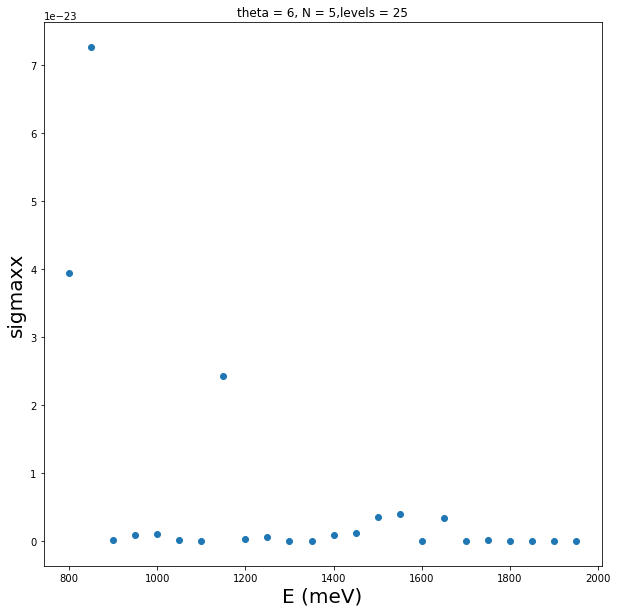

In [77]:
dinam_conds = []
imag_conds = []

Num = 24
angle = 6

for i in range(Num):
    en = 800 + 50*i
    dinam_conds.append([en, DinamCond(angle, en)[0]])
#    dinam_conds.append([angle, en, np.real(DinamCond(angle, en)), np.imag(DinamCond(angle, en))])
#    imag_conds.append([en, np.imag(DinamCond(angle, en))])

dinam_conds
x, y = np.array(dinam_conds).T

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.ylabel('sigmaxx', fontsize=20)
plt.xlabel('E (meV)', fontsize=20)
plt.title( "theta = " + str(angle) + ", N = " + str(N) + ",levels = " + str(levels) )
plt.show()

In [78]:
dinam_conds

[[800, 3.939462673038493e-23],
 [850, 7.26092983544444e-23],
 [900, 1.1156429835340262e-25],
 [950, 9.668093891914797e-25],
 [1000, 1.0412432431640103e-24],
 [1050, 1.1564123623974443e-25],
 [1100, 6.207437433123063e-27],
 [1150, 2.4247660824043605e-23],
 [1200, 3.6577519825860905e-25],
 [1250, 5.563750575880169e-25],
 [1300, 1.2019783515386483e-27],
 [1350, 5.352603672428338e-26],
 [1400, 9.520696916892204e-25],
 [1450, 1.2593834757563901e-24],
 [1500, 3.5307807015810165e-24],
 [1550, 3.980084109057759e-24],
 [1600, 9.27003514845447e-27],
 [1650, 3.3315242776207184e-24],
 [1700, 2.208862252014977e-28],
 [1750, 8.784290705766984e-26],
 [1800, 5.381628989761137e-26],
 [1850, 9.221958148995064e-27],
 [1900, 2.7120661925778484e-28],
 [1950, 2.173353328910756e-27]]

In [97]:
import numpy as np

np.random.seed(42)
arr = np.random.rand(400,300)
r = 30

xx, yy = np.mgrid[-r:r+1, -r:r+1]
circle = xx**2 + yy**2 <= r**2

condition = np.where(arr > .999) # np.where(arr > .5) to benchmark 60k circles
for x,y in zip(*condition):
    # valid indices of the array
    i = slice(max(x-r,0), min(x+r+1, arr.shape[0]))
    j = slice(max(y-r,0), min(y+r+1, arr.shape[1]))

    # visible slice of the circle
    ci = slice(abs(min(x-r, 0)), circle.shape[0] - abs(min(arr.shape[0]-(x+r+1), 0)))
    cj = slice(abs(min(y-r, 0)), circle.shape[1] - abs(min(arr.shape[1]-(y+r+1), 0)))
    
    arr[i, j] += circle[ci, cj]

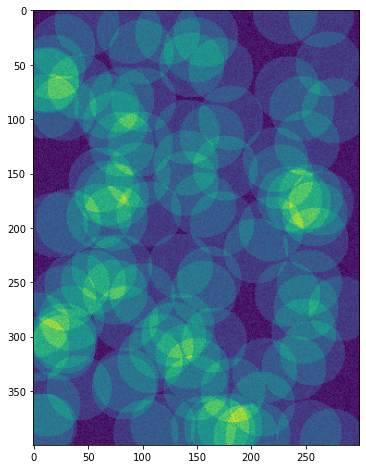

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(arr)
plt.show()

In [ ]:
import numpy as np

xx, yy = np.mgrid[-r:r+1, -r:r+1]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(arr)
plt.show()

In [101]:
np.arange(5)

array([0, 1, 2, 3, 4])